[68 Transformer](https://www.bilibili.com/video/BV1Kq4y1H7FL?p=3&vd_source=1d3a7b81d826789081d8b6870d4fff8e)

In [43]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

基于位置的前馈网络

- 基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是基于位置的（positionwise）的原因。
- 输入X的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量。

In [44]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [45]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.2820, -0.1167, -0.1009, -0.2023, -0.2562,  0.2747,  0.0932,  0.2361],
        [ 0.2820, -0.1167, -0.1009, -0.2023, -0.2562,  0.2747,  0.0932,  0.2361],
        [ 0.2820, -0.1167, -0.1009, -0.2023, -0.2562,  0.2747,  0.0932,  0.2361]],
       grad_fn=<SelectBackward0>)

残差连接和层规范化

层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

In [46]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差连接和层规范化来实现AddNorm类

In [47]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

编码器

先实现编码器中的一个层. 下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

transformer编码器中的任何层都不会改变其输入的形状。

<img src="picture/v2-0edcf81a7675b9834c231442e6629272_1440w.jpg">

In [48]:
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # 多头注意力层
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        # 归一化层
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 前馈层
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

EncoderBlock实现的是这个块

- <img src="picture/屏幕截图 2022-07-03 234944.png">

In [49]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

在实现下面的transformer编码器的代码中，我们堆叠了num_layers个EncoderBlock类的实例。由于我们使用的是值范围在-1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [50]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        # 见附录15
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 这里还是用的sin、cos绝对位置编码
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 按照transformer的架构，得把这个块块重复n次
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        """
        因为位置编码值在-1和1之间
        因此嵌入值乘以嵌入维度的平方根进行缩放，使得embedding参数与位置编码大小相当
        然后再与位置编码相加。
        """
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            """
            追溯源代码看到blk.attention.attention.attention_weights
            相当于masked_softmax(scores, valid_lens)
            """
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

输出看一下

In [51]:
# 这里的qkv、hiddens都是24 
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。


In [52]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        # 为什么需要有i这个参数, 这个得看后面的state
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        '''
        state里面含有三个参数,前面两个分别是enconder传递过来的参数,这个不用管,
        关键是第三个参数,也就是state[2],这里面会储存之前的一些参数.
        '''
        enc_outputs, enc_valid_lens = state[0], state[1]
        '''
        继续解释state[2]
        1. 首先,第[self.i]个块的state[2]初始化为None, 一开始肯定是先训练
        由于此时为none,所以key_values为X, 正常训练, 训练完成后, state[2]被赋值为当前的X
        
        2.预测阶段，同样是第[self.i]个块的state[2], 由于此时state[2]里面已经在训练阶段就
        赋值X了,所以预测阶段会对state[2]重新赋值, 这个赋值是把之前t-1的所有X加上, 在进行预测
        因为预测是滚动预测,预测t时刻需要使用t-1时刻的所有数据
        '''
        if state[2][self.i] is None: # 初始化为none
            key_values = X
        else:
            # 把之前的结果全部加上, 这一步是为预测做准备的.
            key_values = torch.cat((state[2][self.i], X), axis=1) 
            
        # 训练完成后,key_values会被赋值给state[2],而这里的state[2]会依据是训练还是预测状态进行不同的赋值
        state[2][self.i] = key_values 
        
        # 训练过程的话,我们需要通过vaild_lens来屏蔽未来的一些值,避免干扰
        # emmmmm 查了半天,这个self.training是继承与nn.module的, 见附录16
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

- 对比一下enconder的输出
```python
def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))
```

- 第一个注意力+an层，输入的是上一个i-1块的输出
- 第二个注意力+an层，收到的是上一个层和encoder的输入
- 第三个fnn层，没啥可说的，相比encoder的区别也就在于第二个层的不一样

实现的是这个块

<img src="picture/屏幕截图 2022-07-04 004625.png">

In [53]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        # 建立语料库
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # n个块叠加
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 输出层
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

依照transformer架构来实例化编码器－解码器模型。在这里，指定transformer的编码器和解码器都是2层，都使用4头注意力。为了进行序列到序列的学习，我们在“英语－法语”机器翻译数据集上训练transformer模型。

loss 0.031, 11520.7 tokens/sec on cuda:0


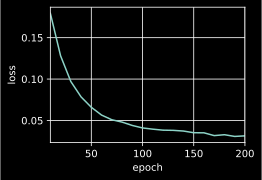

In [54]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用transformer模型将一些英语句子翻译成法语，并且计算它们的BLEU分数。

- 比较关键的参数，hidden_size head数量

In [55]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [56]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

查看encoder的注意力

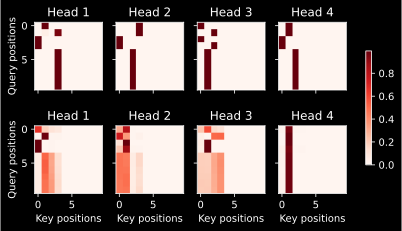

In [57]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [58]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

查看decoder注意力

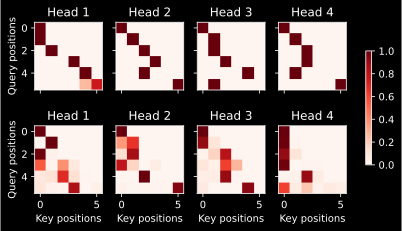

In [59]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

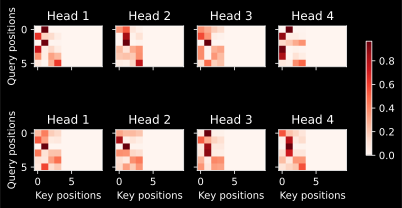

In [60]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

Q/A
- 正余弦编码和自学习位置编码差距大吗？
  - 沐神觉得不大
- 为什么要self.embedding(X) * math.sqrt(self.num_hiddens)？
  - embedding会采用L2 Normalization对向量进行缩放，向量过长的话，每个值就很小了
- nlp有竞赛吗
  - 有的，文本分类
- qkv咋选大小？
  - 按hidden_size理解即可，也是32 64 256这种（bert会到1024）